## NMF-PY Walkthrough

### Input Data Analysis

Input data statistics are provided in PMF5 after the user provides concentration and uncertainty data files.


In [2]:
# Python imports

import os
import sys
import copy
import logging
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data.datahandler import DataHandler
from src.model.base_nmf import BaseSearch
from tests.factor_comparison import FactorComp
from src.utils import calculate_Q

In [3]:
# PMF5 provided input data files
# PMF5 example input files for the St Louis dataset

input_file = os.path.join("D:\\", "projects", "nmf_py", "data", "Dataset-StLouis-con.csv")
uncertainty_file = os.path.join("D:\\", "projects", "nmf_py", "data", "Dataset-StLouis-unc.csv")
output_path = os.path.join("D:\\", "projects", "nmf_py", "output", "StLouis")

In [4]:
# Load data files and calculate statistics
# Category is defaulted to 'Strong' and has not been integrated into the NMF workflow.

dh = DataHandler(
        input_path=input_file,
        uncertainty_path=uncertainty_file,
        output_path=output_path,
        index_col='Date'
    )
dh.metrics

01-Mar-23 15:49:15 - Input and output configured successfully


,Category,S/N,Min,25th,50th,75th,Max
Cd,Strong,0.487385,0.000020,0.000210,0.000435,0.000905,0.03470
Cu,Strong,5.314951,0.000535,0.002010,0.003505,0.008537,1.65000
Fe,Strong,2.287481,0.001710,0.013325,0.024450,0.037300,0.32600
Mn,Strong,8.795804,0.000170,0.001350,0.002485,0.004177,0.16600
Ni,Strong,0.190987,0.000000,0.000302,0.000510,0.000790,0.00676
Pb,Strong,8.421635,0.000580,0.003595,0.006130,0.012575,0.23600
Se,Strong,0.115888,0.000010,0.000410,0.000755,0.001165,0.00371
Zn,Strong,5.009124,0.003580,0.010300,0.017400,0.043650,0.44600
SO4,Strong,6.520647,0.320000,1.995000,2.880000,4.212500,16.90000
NO3,Strong,4.984450,0.021600,1.310000,1.310000,1.765000,10.30000


01-Mar-23 15:49:16 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
01-Mar-23 15:49:16 - Loaded backend module://matplotlib_inline.backend_inline version unknown.


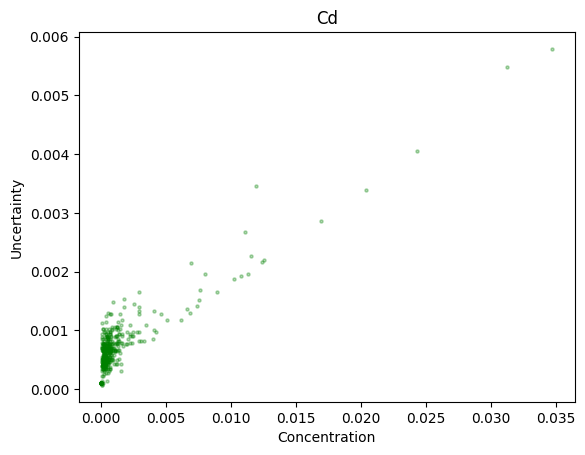

In [5]:
# Scatter plot concentration vs uncertainty
import warnings
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

species = "Cd"

concentration_data = dh.input_data[species]
uncertainty_data = dh.uncertainty_data[species]
plt.scatter(x=concentration_data, y=uncertainty_data, s=5, c='green', alpha=0.3)
plt.title(f"{species}")
plt.xlabel("Concentration")
plt.ylabel("Uncertainty")
plt.show()

In [6]:
# Base model paramters

n_components = 4            # number of factors
method1 = "mu"               # minimization algorithm: 'mu' multiplicative update - Kullback-Leibler, 'euc' multiplicative update - frobenius, 'is' multiplicative update - itakura-saito, 'gd' gradient descent, 'cg' conjugate descent
seed = 42                   # randomization seed
epochs = 10                # number of models to create
max_iterations = 20000      # max number of iterations to run for multiplicative update models
converge_delta = 0.01       # the amount of change between iterations for a multiplicative model considered converged
converge_n = 100            # the number of iterations required with a loss change of less than converge_delta for the model to be considered converged

V = dh.input_data_processed
U = dh.uncertainty_data_processed

In [ ]:
# Kullback-Leibler divergence with weights
# https://www.researchgate.net/publication/221080181_Kullback-Leibler_Divergence_for_Nonnegative_Matrix_Factorization
# https://perso.uclouvain.be/paul.vandooren/publications/BlondelHV07.pdf

base = BaseSearch(n_components=n_components, method=method1, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
base.train()

Epoch: 0, Seed: 8925, Best Q(true): 29371.5234375, Q(true): 43621.12109375:  56%|▌| 11203/20000 [00:47<00:36, 237.99it/
Epoch: 1, Seed: 77395, Best Q(true): 26445.04296875, Q(true): 26445.05078125:  22%|▏| 4320/20000 [00:18<01:07, 233.27it
Epoch: 3, Seed: 43887, Best Q(true): 29355.52734375, Q(true): 43492.69140625:  55%|▌| 10958/20000 [00:47<00:38, 232.89i
Epoch: 4, Seed: 43301, Best Q(true): 26215.734375, Q(true): 40698.55078125:  59%|▌| 11772/20000 [00:46<00:32, 251.52it/
Epoch: 6, Seed: 8594, Best Q(true): 29343.9140625, Q(true): 43489.16015625:  55%|▌| 10935/20000 [00:45<00:37, 241.99it/
Epoch: 7, Seed: 69736, Best Q(true): 30466.765625, Q(true): 30466.76953125:  10%| | 2094/20000 [00:10<01:25, 208.74it/s
Epoch: 8, Seed: 20146, Best Q(true): 27447.85546875, Q(true): 27447.859375:  26%|▎| 5153/20000 [00:19<00:55, 269.60it/s
Epoch: 9, Seed: 9417, Best Q(true): 30450.28515625, Q(true): 44623.37890625:  52%|▌| 10436/20000 [00:33<00:29, 325.55it

In [8]:
save_output_path = f"{method1}-e{epochs}-c{n_components}.json"
base.save(output_name=save_output_path)

01-Mar-23 15:58:37 - Results saved to: .\mu-e10-c4.json


In [9]:
pmf_file = os.path.join("D:\\", "projects", "nmf_py", "data", f"stlouis_{n_components}f_profiles.txt")
pmf_residuals_file = os.path.join("D:\\", "projects", "nmf_py", "data", f"stlouis_{n_components}f_residuals.txt")
profile_comparison = FactorComp(nmf_output=save_output_path, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
profile_comparison.compare(PMF_Q=pmf_q)

R2 - Model: 9, Best permutations: ['Factor 2', 'Factor 1', 'Factor 4', 'Factor 3'], Average: 0.9912357423172626, Factors: [0.9958932690383266, 0.9928403092149023, 0.995325480617675, 0.9808839103981467]
PMF5 Q(true): 24620.1796875, NMF-PY Model 9 Q(true): 30450.28515625


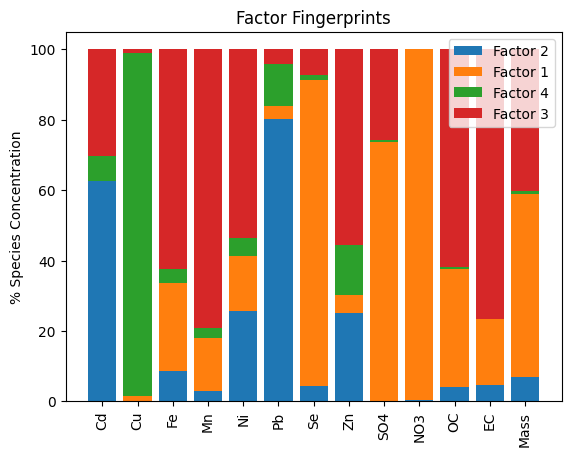

In [10]:
# Fingerprint Profile

warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

totals = np.sum(base.results[base.best_epoch]['H'], axis=0)
scaled_factors = base.results[base.best_epoch]['H'] / totals

width = 0.10
fig, ax = plt.subplots()

plot_bottom = np.zeros(len(dh.features))
label = True

for i, scaled_factor in enumerate(scaled_factors):
    p = ax.bar(dh.features, 100*scaled_factor, label=profile_comparison.factor_map[i], bottom=plot_bottom)
    plot_bottom += 100*scaled_factor
    
ax.set_title("Factor Fingerprints")
ax.legend(loc="upper right")
plt.ylabel("% Species Concentration")
plt.xticks(rotation=90)
plt.show()

In [11]:
# LS-NMF (weighted frobenius divergence) - available in NMF R package
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1450309/

method2 = "euc"
# max_iterations = 20000
converge_delta = 0.1
# converge_n = 100
base2 = BaseSearch(n_components=n_components, method=method2, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
base2.train()

Epoch: 0, Seed: 8925, Best Q(true): 66010.359375, Q(true): 74775.53125:  55%|█▋ | 10922/20000 [00:39<00:33, 273.35it/s]
Epoch: 1, Seed: 77395, Best Q(true): 66693.71875, Q(true): 74774.0390625:  55%|▌| 10948/20000 [00:38<00:31, 285.22it/s]
Epoch: 6, Seed: 8594, Best Q(true): 67284.171875, Q(true): 74875.65625:  55%|█▋ | 10925/20000 [00:34<00:28, 312.99it/s]
Epoch: 9, Seed: 9417, Best Q(true): 65355.05859375, Q(true): 74694.3203125:  54%|▌| 10802/20000 [00:35<00:30, 304.58it/
01-Mar-23 16:05:02 - Results - Best Model: 3, Converged: False, Q: 59047.8515625
01-Mar-23 16:05:02 - Runtime: 6.11 min(s)


In [12]:
save_output_path2 = f"{method2}-e{epochs}-c{n_components}.json"
base2.save(output_name=save_output_path)
profile_comparison2 = FactorComp(nmf_output=save_output_path2, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
pmf_q = calculate_Q(profile_comparison2.pmf_residuals.values, dh.uncertainty_data_processed)
profile_comparison2.compare(PMF_Q=pmf_q)

01-Mar-23 16:05:02 - Results saved to: .\mu-e10-c4.json


R2 - Model: 0, Best permutations: ['Factor 4', 'Factor 3', 'Factor 1', 'Factor 2'], Average: 0.8184371952445055, Factors: [0.39759929650204123, 0.9603750715438804, 0.9589650706881607, 0.9568093422439399]
PMF5 Q(true): 24620.1796875, NMF-PY Model 0 Q(true): 67420.5


In [ ]:
# Itakura-Saito Divergence
# https://www.irit.fr/~Cedric.Fevotte/publications/journals/neco09_is-nmf.pdf

# method3 = "is"
# base3 = BaseSearch(n_components=n_components, method=method3, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
# base3.train()
# save_output_path = f"{method3}-e{epochs}-c{n_components}.json"
# base3.save(output_name=save_output_path)
# profile_comparison = FactorComp(nmf_output=save_output_path, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
# pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
# profile_comparison.compare(PMF_Q=pmf_q)

In [ ]:
# Projected Gradient Descent
# https://www.csie.ntu.edu.tw/~cjlin/papers/pgradnmf.pdf

# method = "gd"
# base = BaseSearch(n_components=n_components, method=method, V=V, U=U, seed=seed, epochs=epochs, max_iterations=1, converge_delta=converge_delta, converge_n=converge_n)
# base.train()
# save_output_path = f"{method}-e{epochs}-c{n_components}.json"
# base.save(output_name=save_output_path)
# profile_comparison = FactorComp(nmf_output=save_output_path, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
# pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
# profile_comparison.compare(PMF_Q=pmf_q)

In [ ]:
# Projected Conjugate Gradient
# https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=abc10f7fa030823e284154fa84ea27e3099a038d

# method = "cg"
# base = BaseSearch(n_components=n_components, method=method, V=V, U=U, seed=seed, epochs=epochs, max_iterations=1, converge_delta=converge_delta, converge_n=converge_n)
# base.train()
# save_output_path = f"{method}-e{epochs}-c{n_components}.json"
# base.save(output_name=save_output_path)
# profile_comparison = FactorComp(nmf_output=save_output_path, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
# pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
# profile_comparison.compare(PMF_Q=pmf_q)